In [2]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}


Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.


In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive

In [0]:
#unzip Autopilot folder as data is inside there
!unzip /content/drive/Car_data_set/Autopilot-TensorFlow-master.zip >temp.txt


In [5]:
!ls /content/Autopilot-TensorFlow-master/

cmd_output	 logs	      run_dataset.py  Self_driving_car.ipynb
driving_data.py  model.py     run.py	      steering_wheel_image.jpg
driving_dataset  __pycache__  save	      train.py
License.txt	 README.md    save copy


In [6]:
import numpy as np
import pandas as pd
import os, shutil
from keras.models import Model
from keras import layers
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D,AveragePooling2D,BatchNormalization
from keras.layers import Activation, Dropout, Flatten, Dense,Input
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from scipy import pi
import matplotlib.pyplot as plt
from keras.applications.inception_v3 import InceptionV3
from keras.layers import GlobalAveragePooling2D,GlobalMaxPooling2D
from keras.regularizers import l2
from keras.optimizers import Adam

Using TensorFlow backend.


In [7]:
xs = []
ys = []
original_data_path = r"/content/Autopilot-TensorFlow-master/driving_dataset"
#train_data_path = r"/content/Autopilot-TensorFlow-master/train_driving_dataset"
#val_data_path = r"/content/Autopilot-TensorFlow-master/val_driving_dataset"
#test_data_path = r"/content/Autopilot-TensorFlow-master/test_driving_dataset"

#read data.txt
with open(original_data_path +"/data.txt") as f:
    for line in f:
        xs.append(original_data_path+"/" + line.split()[0])
        #the paper by Nvidia uses the inverse of the turning radius,
        #but steering wheel angle is proportional to the inverse of turning radius
        #so the steering wheel angle in radians is used as the output
        ys.append(float(line.split()[1]) * pi / 180)

#get number of images
num_images = len(xs)
val_start_point = int(len(xs) * 0.8)
val_end_point = int(len(xs)*1)
                      
train_xs = xs[:val_start_point]
train_ys = ys[:val_start_point]
val_xs = xs[val_start_point : val_end_point]
val_ys = ys[val_start_point : val_end_point]
test_xs = xs[val_end_point:]
test_ys = ys[val_end_point:]
print("Total Number of Data-set: "+str(num_images))
print("Total Number of Train Data-set: "+str(len(train_xs)))
print("Total Number of Validation Data-set: "+str(len(val_xs)))
print("Total Number of Test Data-set: "+str(len(test_xs)))



Total Number of Data-set: 45406
Total Number of Train Data-set: 36324
Total Number of Validation Data-set: 9082
Total Number of Test Data-set: 0


In [8]:
read_image_height=100
read_image_width=150

image_height=50
image_width=150
channels = 3

train_dataset = np.ndarray(shape=(len(train_xs), image_height, image_width, channels),
                     dtype=np.float32)
val_dataset = np.ndarray(shape=(len(val_xs), image_height, image_width, channels),
                     dtype=np.float32)
test_dataset = np.ndarray(shape=(len(test_xs), image_height, image_width, channels),
                     dtype=np.float32)

i = 0
for file in train_xs:
    img = load_img(file, target_size=(read_image_height, read_image_width)) # this is a PIL image(PIL- Python Imaging Libaray)
    # Convert to Numpy Array
    x = img_to_array(img)  
    #x = x.reshape((66,100,1)) ---> not required we have given target_size in load_img
    # Normalize
    x *= 1./255
    train_dataset[i] = x[40:90,:,:]
    del(x)
    i += 1
    if i % 10000 == 0:
        print("%d images to array" % i)
print("All Train images to array!")


i = 0
for file in val_xs:
    img = load_img(file, target_size=(read_image_height, read_image_width)) # this is a PIL image(PIL- Python Imaging Libaray)
    # Convert to Numpy Array
    x = img_to_array(img)  
    #x = x.reshape((66,100,1)) ---> not required we have given target_size in load_img
    # Normalize
    x *= 1./255
    val_dataset[i] = x[40:90,:,:]
    del(x)
    i += 1
    if i % 10000 == 0:
        print("%d images to array" % i)
print("All validation images to array!")        

"""
i = 0
for file in test_xs:
    img = load_img(file, target_size=(read_image_height, read_image_width)) # this is a PIL image(PIL- Python Imaging Libaray)
    # Convert to Numpy Array
    x = img_to_array(img)  
    #x = x.reshape((66,100,1)) ---> not required we have given target_size in load_img
    # Normalize
    x *= 1./255
    test_dataset[i] = x[75:175,:,:]
    del(x)
    i += 1
    if i % 10000 == 0:
        print("%d images to array" % i)
        
print("All Test images to array!")

"""

10000 images to array
20000 images to array
30000 images to array
All Train images to array!
All validation images to array!


'\ni = 0\nfor file in test_xs:\n    img = load_img(file, target_size=(read_image_height, read_image_width)) # this is a PIL image(PIL- Python Imaging Libaray)\n    # Convert to Numpy Array\n    x = img_to_array(img)  \n    #x = x.reshape((66,100,1)) ---> not required we have given target_size in load_img\n    # Normalize\n    x *= 1./255\n    test_dataset[i] = x[75:175,:,:]\n    del(x)\n    i += 1\n    if i % 10000 == 0:\n        print("%d images to array" % i)\n        \nprint("All Test images to array!")\n\n'

In [0]:
def arctanh(x):
  return 1/K.tanh(x)

In [0]:
#create small model
input_size = (image_height,image_width,channels)
#crop_size = ((75,25),(10,10))
act_funct = "relu"
init = "he_normal"
l2_rate = 0.0001
keep_prob = 0.1
keep_prob_dense = 0.2
def create_model(act_funct='relu',keep_prob_dense = 0.2,opt = "adam",last_act = 'tanh',ep=10):
  model = Sequential()
  
  model.add(Conv2D(24, (5, 5),strides=(2, 2), padding="valid", activation=act_funct,input_shape=input_size,use_bias=True,
            kernel_initializer=init, bias_initializer=init, 
            kernel_regularizer=l2(l2_rate), bias_regularizer=l2(l2_rate)))
  #model.add(Dropout(keep_prob))
  
  model.add(Conv2D(36, (5, 5),strides=(2, 2), padding="valid", activation=act_funct,input_shape=input_size,use_bias=True,
            kernel_initializer=init, bias_initializer=init, 
            kernel_regularizer=l2(l2_rate), bias_regularizer=l2(l2_rate)))
  #model.add(Dropout(keep_prob))
  
  model.add(Conv2D(48, (5, 5),strides=(2, 2), padding="valid", activation=act_funct,input_shape=input_size,use_bias=True,
            kernel_initializer=init, bias_initializer=init, 
            kernel_regularizer=l2(l2_rate), bias_regularizer=l2(l2_rate)))
  #model.add(Dropout(keep_prob))
  
  model.add(Conv2D(64, (3, 3), padding="same", activation=act_funct,input_shape=input_size,use_bias=True,
            kernel_initializer=init, bias_initializer=init, 
            kernel_regularizer=l2(l2_rate), bias_regularizer=l2(l2_rate)))
  model.add(Dropout(keep_prob))
  
  model.add(Conv2D(64, (3, 3), padding="same", activation=act_funct,input_shape=input_size,use_bias=True,
            kernel_initializer=init, bias_initializer=init, 
            kernel_regularizer=l2(l2_rate), bias_regularizer=l2(l2_rate)))
  model.add(Dropout(keep_prob))
  
  
  #FC dence layer
  model.add(Flatten())
  model.add(Dropout(keep_prob_dense))
  model.add(Dense(1164, activation=act_funct,use_bias=True,
            kernel_initializer=init, bias_initializer=init, 
            kernel_regularizer=l2(l2_rate), bias_regularizer=l2(l2_rate)))
  model.add(Dropout(keep_prob_dense))
  model.add(Dense(100, activation=act_funct,use_bias=True,
            kernel_initializer=init, bias_initializer=init, 
            kernel_regularizer=l2(l2_rate), bias_regularizer=l2(l2_rate)))
  model.add(Dropout(keep_prob_dense))
  model.add(Dense(50, activation=act_funct,use_bias=True,
            kernel_initializer=init, bias_initializer=init, 
            kernel_regularizer=l2(l2_rate), bias_regularizer=l2(l2_rate)))
  model.add(Dropout(keep_prob_dense))
  model.add(Dense(10, activation=act_funct,use_bias=True,
            kernel_initializer=init, bias_initializer=init, 
            kernel_regularizer=l2(l2_rate), bias_regularizer=l2(l2_rate)))
  #model.add(Dropout(keep_prob_dense))
  #arctanh
  #model.add(Dense(1,activation=arctanh))
  if len(last_act) == 0:
    model.add(Dense(1))  
  else:
    model.add(Dense(1,activation = last_act))
  
  
  model.compile(loss='mse',optimizer=opt)
  history = model.fit(x=train_dataset, y=train_ys, batch_size=64, epochs=ep, verbose=1, validation_data=(val_dataset,val_ys))
  return model


In [0]:
#create_model('relu',0.2,"Adagrad",'tanh',)
model = create_model('relu',0.2,"Adamax",'tanh',50)

Train on 36324 samples, validate on 9082 samples
Epoch 1/50
36324/36324 [==============================] - 21s 568us/step - loss: 0.4287 - val_loss: 0.4613
Epoch 2/50
33856/36324 [==========================>...] - ETA: 1s - loss: 0.3023

36324/36324 [==============================] - 18s 483us/step - loss: 0.2981 - val_loss: 0.3183
Epoch 3/50
36324/36324 [==============================] - 18s 485us/step - loss: 0.2208 - val_loss: 0.2728
Epoch 4/50
21696/36324 [================>.............] - ETA: 6s - loss: 0.1903

36324/36324 [==============================] - 18s 487us/step - loss: 0.1884 - val_loss: 0.3814
Epoch 5/50
36324/36324 [==============================] - 18s 489us/step - loss: 0.1701 - val_loss: 0.2625
Epoch 6/50
18624/36324 [==============>...............] - ETA: 8s - loss: 0.1639

36324/36324 [==============================] - 18s 490us/step - loss: 0.1548 - val_loss: 0.2553
Epoch 7/50
36324/36324 [==============================] - 18s 484us/step - loss: 0.1507 - val_loss: 0.2693
Epoch 8/50
17728/36324 [=============>................] - ETA: 8s - loss: 0.1445

36324/36324 [==============================] - 18s 486us/step - loss: 0.1441 - val_loss: 0.2573
Epoch 9/50
36324/36324 [==============================] - 18s 487us/step - loss: 0.1379 - val_loss: 0.2535
Epoch 10/50
17600/36324 [=============>................] - ETA: 8s - loss: 0.1365

36324/36324 [==============================] - 18s 485us/step - loss: 0.1368 - val_loss: 0.2473
Epoch 11/50
36324/36324 [==============================] - 18s 485us/step - loss: 0.1323 - val_loss: 0.2627
Epoch 12/50
17472/36324 [=============>................] - ETA: 8s - loss: 0.1328

36324/36324 [==============================] - 18s 485us/step - loss: 0.1332 - val_loss: 0.3002
Epoch 13/50
36324/36324 [==============================] - 18s 487us/step - loss: 0.1291 - val_loss: 0.2662
Epoch 14/50
17344/36324 [=============>................] - ETA: 8s - loss: 0.1209

36324/36324 [==============================] - 18s 487us/step - loss: 0.1280 - val_loss: 0.2413
Epoch 15/50
36324/36324 [==============================] - 18s 486us/step - loss: 0.1283 - val_loss: 0.2484
Epoch 16/50
17344/36324 [=============>................] - ETA: 8s - loss: 0.1200

36324/36324 [==============================] - 18s 489us/step - loss: 0.1276 - val_loss: 0.2689
Epoch 17/50
36324/36324 [==============================] - 18s 484us/step - loss: 0.1255 - val_loss: 0.2440
Epoch 18/50
17344/36324 [=============>................] - ETA: 8s - loss: 0.1122

36324/36324 [==============================] - 18s 486us/step - loss: 0.1254 - val_loss: 0.2981
Epoch 19/50
36324/36324 [==============================] - 18s 486us/step - loss: 0.1237 - val_loss: 0.2713
Epoch 20/50
17344/36324 [=============>................] - ETA: 8s - loss: 0.1202

36324/36324 [==============================] - 18s 485us/step - loss: 0.1259 - val_loss: 0.2739
Epoch 21/50
36324/36324 [==============================] - 18s 486us/step - loss: 0.1224 - val_loss: 0.2699
Epoch 22/50
17344/36324 [=============>................] - ETA: 8s - loss: 0.1234

36324/36324 [==============================] - 18s 485us/step - loss: 0.1217 - val_loss: 0.2627
Epoch 23/50
36324/36324 [==============================] - 18s 488us/step - loss: 0.1229 - val_loss: 0.3160
Epoch 24/50
17344/36324 [=============>................] - ETA: 8s - loss: 0.1273

36324/36324 [==============================] - 18s 487us/step - loss: 0.1222 - val_loss: 0.2454
Epoch 25/50
36324/36324 [==============================] - 18s 487us/step - loss: 0.1207 - val_loss: 0.2414
Epoch 26/50
17344/36324 [=============>................] - ETA: 8s - loss: 0.1222

36324/36324 [==============================] - 18s 487us/step - loss: 0.1224 - val_loss: 0.2695
Epoch 27/50
36324/36324 [==============================] - 18s 488us/step - loss: 0.1203 - val_loss: 0.2608
Epoch 28/50
17344/36324 [=============>................] - ETA: 8s - loss: 0.1133

36324/36324 [==============================] - 18s 488us/step - loss: 0.1191 - val_loss: 0.2698
Epoch 29/50
36324/36324 [==============================] - 18s 487us/step - loss: 0.1203 - val_loss: 0.2737
Epoch 30/50
17344/36324 [=============>................] - ETA: 8s - loss: 0.1183

36324/36324 [==============================] - 18s 489us/step - loss: 0.1197 - val_loss: 0.2515
Epoch 31/50
36324/36324 [==============================] - 18s 487us/step - loss: 0.1186 - val_loss: 0.2854
Epoch 32/50
17344/36324 [=============>................] - ETA: 8s - loss: 0.1172

36324/36324 [==============================] - 18s 485us/step - loss: 0.1178 - val_loss: 0.2912
Epoch 33/50
36324/36324 [==============================] - 18s 484us/step - loss: 0.1181 - val_loss: 0.2637
Epoch 34/50
17344/36324 [=============>................] - ETA: 8s - loss: 0.1116

36324/36324 [==============================] - 18s 485us/step - loss: 0.1181 - val_loss: 0.2316
Epoch 35/50
36324/36324 [==============================] - 18s 484us/step - loss: 0.1178 - val_loss: 0.2531
Epoch 36/50
17344/36324 [=============>................] - ETA: 8s - loss: 0.1106

36324/36324 [==============================] - 18s 486us/step - loss: 0.1175 - val_loss: 0.2283
Epoch 37/50
36324/36324 [==============================] - 17s 481us/step - loss: 0.1172 - val_loss: 0.3152
Epoch 38/50
17344/36324 [=============>................] - ETA: 8s - loss: 0.1107

36324/36324 [==============================] - 18s 485us/step - loss: 0.1159 - val_loss: 0.2561
Epoch 39/50
36324/36324 [==============================] - 18s 484us/step - loss: 0.1165 - val_loss: 0.2452
Epoch 40/50
17344/36324 [=============>................] - ETA: 8s - loss: 0.1186

36324/36324 [==============================] - 18s 487us/step - loss: 0.1181 - val_loss: 0.2717
Epoch 41/50
36324/36324 [==============================] - 18s 486us/step - loss: 0.1161 - val_loss: 0.2150
Epoch 42/50
17344/36324 [=============>................] - ETA: 8s - loss: 0.1162

36324/36324 [==============================] - 18s 485us/step - loss: 0.1157 - val_loss: 0.2835
Epoch 43/50
36324/36324 [==============================] - 18s 489us/step - loss: 0.1159 - val_loss: 0.2288
Epoch 44/50
17344/36324 [=============>................] - ETA: 8s - loss: 0.1109

36324/36324 [==============================] - 18s 487us/step - loss: 0.1169 - val_loss: 0.2445
Epoch 45/50
36324/36324 [==============================] - 18s 487us/step - loss: 0.1149 - val_loss: 0.2262
Epoch 46/50
17344/36324 [=============>................] - ETA: 8s - loss: 0.1249

36324/36324 [==============================] - 18s 486us/step - loss: 0.1149 - val_loss: 0.2666
Epoch 47/50
36324/36324 [==============================] - 18s 485us/step - loss: 0.1155 - val_loss: 0.2296
Epoch 48/50
11456/36324 [========>.....................] - ETA: 11s - loss: 0.1046

In [0]:
model.save("new_Adamax50_over_fit_relu_model.h5")
# saving puting file into drive folder. if not using colab it can skip
!cp new_Adamax50_over_fit_relu_model.h5 /content/drive/Car_data_set/

In [18]:
print("######################## ('relu',0.1, Adagrad,'tanh')  ##################")
create_model('relu',0.1,"Adagrad",'tanh')

print("######################## ('relu',0.2,Adamax,'tanh')  ##################")
create_model('relu',0.2,"Adamax",'tanh')

print("######################## ('relu',0.1,"Adadelta",'tanh')  ##################")
create_model('relu',0.1,"Adadelta",'tanh')

print("######################## ('relu',0.1, Adagrad,'tanh')  ##################")
create_model('relu',0.4,"Adagrad",'')
create_model('relu',0.4,"Adamax",'')
create_model('relu',0.4,"Nadam",'')
create_model('relu',0.4,"Adadelta",'')
create_model('elu',0.2,"Adagrad",'')

SyntaxError: ignored

In [0]:
adam = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=0.001, decay=0.0, amsgrad=False)


In [60]:
#history = model.fit_generator(train_generator,steps_per_epoch=t_steps_per_e,epochs=ep,validation_data=val_generator,validation_steps=v_steps_per_e,callbacks=[tb,checkpointer])


Train on 36324 samples, validate on 9082 samples
Epoch 1/30
36324/36324 [==============================] - 21s 575us/step - loss: 0.4374 - val_loss: 0.2005
Epoch 2/30
33984/36324 [===========================>..] - ETA: 0s - loss: 0.3252

36324/36324 [==============================] - 17s 463us/step - loss: 0.3266 - val_loss: 0.1997
Epoch 3/30
36324/36324 [==============================] - 17s 465us/step - loss: 0.3245 - val_loss: 0.1973
Epoch 4/30
21696/36324 [================>.............] - ETA: 6s - loss: 0.2968

36324/36324 [==============================] - 17s 460us/step - loss: 0.3007 - val_loss: 0.2127
Epoch 5/30
36324/36324 [==============================] - 17s 461us/step - loss: 0.2640 - val_loss: 0.2057
Epoch 6/30
18624/36324 [==============>...............] - ETA: 7s - loss: 0.2257

36324/36324 [==============================] - 17s 463us/step - loss: 0.2511 - val_loss: 0.2157
Epoch 7/30
36324/36324 [==============================] - 17s 465us/step - loss: 0.1972 - val_loss: 0.2350
Epoch 8/30
17984/36324 [=============>................] - ETA: 7s - loss: 0.1697

36324/36324 [==============================] - 17s 470us/step - loss: 0.1644 - val_loss: 0.2215
Epoch 9/30
36324/36324 [==============================] - 17s 464us/step - loss: 0.1405 - val_loss: 0.2349
Epoch 10/30
17600/36324 [=============>................] - ETA: 8s - loss: 0.1329

36324/36324 [==============================] - 17s 463us/step - loss: 0.1287 - val_loss: 0.3502
Epoch 11/30
36324/36324 [==============================] - 17s 462us/step - loss: 0.1140 - val_loss: 0.2733
Epoch 12/30
17472/36324 [=============>................] - ETA: 8s - loss: 0.1069

36324/36324 [==============================] - 17s 463us/step - loss: 0.1038 - val_loss: 0.2550
Epoch 13/30
36324/36324 [==============================] - 17s 466us/step - loss: 0.0936 - val_loss: 0.2683
Epoch 14/30
17216/36324 [=============>................] - ETA: 8s - loss: 0.0927

36324/36324 [==============================] - 17s 464us/step - loss: 0.0877 - val_loss: 0.3187
Epoch 15/30
36324/36324 [==============================] - 17s 465us/step - loss: 0.0916 - val_loss: 0.2994
Epoch 16/30
17344/36324 [=============>................] - ETA: 8s - loss: 0.0816

36324/36324 [==============================] - 17s 463us/step - loss: 0.0814 - val_loss: 0.2940
Epoch 17/30
36324/36324 [==============================] - 17s 461us/step - loss: 0.0758 - val_loss: 0.2959
Epoch 18/30
17344/36324 [=============>................] - ETA: 7s - loss: 0.0776

36324/36324 [==============================] - 17s 459us/step - loss: 0.0748 - val_loss: 0.2898
Epoch 19/30
36324/36324 [==============================] - 17s 461us/step - loss: 0.0684 - val_loss: 0.2926
Epoch 20/30
17344/36324 [=============>................] - ETA: 8s - loss: 0.0660

36324/36324 [==============================] - 17s 462us/step - loss: 0.0680 - val_loss: 0.2786
Epoch 21/30
36324/36324 [==============================] - 17s 463us/step - loss: 0.0658 - val_loss: 0.2744
Epoch 22/30
17344/36324 [=============>................] - ETA: 8s - loss: 0.0687

36324/36324 [==============================] - 17s 461us/step - loss: 0.0652 - val_loss: 0.2907
Epoch 23/30
36324/36324 [==============================] - 17s 462us/step - loss: 0.0635 - val_loss: 0.3301
Epoch 24/30
17344/36324 [=============>................] - ETA: 8s - loss: 0.0592

36324/36324 [==============================] - 17s 461us/step - loss: 0.0614 - val_loss: 0.2944
Epoch 25/30
36324/36324 [==============================] - 17s 461us/step - loss: 0.0594 - val_loss: 0.3060
Epoch 26/30
17344/36324 [=============>................] - ETA: 8s - loss: 0.0529

36324/36324 [==============================] - 17s 466us/step - loss: 0.0588 - val_loss: 0.3037
Epoch 27/30
36324/36324 [==============================] - 17s 466us/step - loss: 0.0604 - val_loss: 0.2877
Epoch 28/30
17344/36324 [=============>................] - ETA: 8s - loss: 0.0537

36324/36324 [==============================] - 17s 464us/step - loss: 0.0576 - val_loss: 0.3043
Epoch 29/30
36324/36324 [==============================] - 17s 458us/step - loss: 0.0547 - val_loss: 0.2603
Epoch 30/30
17344/36324 [=============>................] - ETA: 8s - loss: 0.0556

36324/36324 [==============================] - 17s 460us/step - loss: 0.0536 - val_loss: 0.2712


In [0]:
model.save("100_under_fit_relu_model.h5")
# saving puting file into drive folder. if not using colab it can skip
!cp 100_under_fit_relu_model.h5 /content/drive/Car_data_set/

In [0]:
from keras.models import load_model
model1 = load_model("/content/drive/Car_data_set/100_over_fit_relu_model.h5")

In [0]:
val_pre = model1.predict(val_dataset)
train_pre = model1.predict(train_dataset)

In [11]:
plt.plot(range(val_pre), val_pre, 'b', label='Training loss')
plt.plot(range(train_pre), train_pre, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

TypeError: ignored

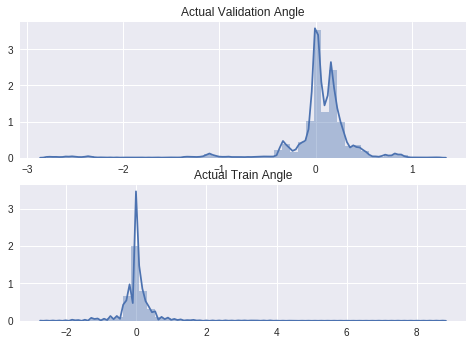

In [25]:
import seaborn as sb
plt.subplot(211)
plt.title("Actual Validation Angle")
sb.distplot(val_ys)

plt.subplot(212)
plt.title("Actual Train Angle")
sb.distplot(train_ys)
plt.show()

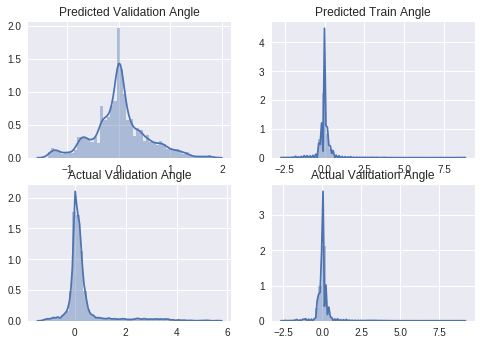

In [20]:
import seaborn as sb
plt.subplot(221)
plt.title("Actual Validation Angle")
sb.distplot(val_ys)

plt.subplot(222)
plt.title("Actual Train Angle")
sb.distplot(train_ys)

plt.subplot(223)
plt.title("Predicted Validation Angle")
sb.distplot(val_pre)

plt.subplot(224)
plt.title("Predicted Validation Angle")
sb.distplot(train_pre)
plt.show()

In [0]:
from keras.layers import ELU

In [0]:
init = 'glorot_normal'
        activation = 'relu'
        keep_prob_dense = 0.7
        keep_prob = 0.5
        
        model = Sequential()
        
        ### pre-processing
        model.add(Cropping2D(cropping=((40,25), (0,0)), input_shape=(160,320,3)))
        model.add(Lambda(lambda x: K.tf.image.resize_images(x, (66,200)))) # resize image
        model.add(Lambda(lambda x: x/255.0 -0.5)) # normalization
        
        ### Convnet
        model.add(Convolution2D(24,5,5, subsample=(2,2), border_mode='valid', init=init))
        model.add(Activation(activation))
        model.add(Dropout(keep_prob))
        
        # 5x5 convolution factorization
#         model.add(BatchNormalization())
        model.add(Convolution2D(36,3,1, init=init))
        model.add(Convolution2D(36,1,3, init=init))
        model.add(Convolution2D(36,3,3, subsample=(2,2), border_mode='valid', init=init))
        model.add(Activation(activation))
        model.add(Dropout(keep_prob))
        
        # 5x5 factorfization
#         model.add(BatchNormalization())
        model.add(Convolution2D(48,3,1, init=init))
        model.add(Convolution2D(48,1,3, init=init))
        model.add(Convolution2D(48,3,3, subsample=(2,2), border_mode='valid', init=init))
        model.add(Activation(activation))
        model.add(Dropout(keep_prob))

        
        # 3x3 factorization
#         model.add(BatchNormalization())
        model.add(Convolution2D(48,3,1, init=init))
        model.add(Convolution2D(64,1,3, init=init))
        model.add(Activation(activation))
        model.add(Dropout(keep_prob))

        # 3x3 factorization
#         model.add(BatchNormalization())
        model.add(Convolution2D(48,3,1, init=init))
        model.add(Convolution2D(64,1,3, init=init))
        model.add(Activation(activation))
        model.add(Dropout(keep_prob))
        
        # average pooling
        model.add(AveragePooling2D(pool_size=(1,6)))
        
        # FC
        model.add(Flatten())
        model.add(Dense(100, init=init))
        model.add(Dropout(keep_prob_dense))
        model.add(Dense(50, init=init))
        model.add(Dropout(keep_prob_dense))
        model.add(Dense(10, init=init))
        model.add(Dropout(keep_prob_dense))
        model.add(Dense(1, init=init))
        
        # model.summary
        
        return(model)

In [0]:
#create small model
input_size = (image_height,image_width,channels)
act_funct = "relu"
def create_model():
  model = Sequential()
  #model.add(Conv2D(12, (1, 1), activation=act_funct,input_shape=input_size)) #inception layer
  model.add(Conv2D(16, (8, 8), strides=(4, 4), padding="same",input_shape=input_size))
  model.add(ELU())
  model.add(Conv2D(32, (5, 5), strides=(2, 2), padding="same"))
  model.add(ELU())
  model.add(Conv2D(64, (5, 5), strides=(2, 2), padding="same"))
  model.add(Flatten())
  model.add(Dropout(.2))
  model.add(ELU())
  model.add(Dense(512))
  model.add(Dropout(.5))
  model.add(ELU())
  model.add(Dense(1))
  return model

model = create_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_28 (Conv2D)           (None, 17, 25, 16)        3088      
_________________________________________________________________
elu_9 (ELU)                  (None, 17, 25, 16)        0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 9, 13, 32)         12832     
_________________________________________________________________
elu_10 (ELU)                 (None, 9, 13, 32)         0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 5, 7, 64)          51264     
_________________________________________________________________
flatten_5 (Flatten)          (None, 2240)              0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 2240)              0         
__________